# Step 3: Model Building — Baseline CNN

In this step, we define, train, evaluate, and save our first convolutional neural network (CNN) model, which serves as a **performance baseline** for later comparison and quantization.

---

## 3.1 Objective

This step supports **Hypothesis 1**:  
> A lightweight CNN trained on grayscale fruit images can achieve reasonable classification accuracy, even with minimal augmentation.

It also prepares the model for:

- Comparison with MobileNetV2 (**Hypothesis 2**)  
- Post-training quantization (**Hypothesis 3**)

---

## 3.2 CNN Architecture (Grayscale-Compatible)

Our baseline CNN is compact and designed for `100×100` **grayscale images** (1 input channel), as established in Step 2.

It consists of:

- 3 convolutional layers with ReLU activation and MaxPooling  
- 2 fully connected layers with ReLU and Dropout  
- A final softmax classifier layer for 8-class output

> ✅ **Note**: The first convolutional layer uses `in_channels=1` to match the grayscale input format.

---

## 3.3 Training Configuration

- **Loss Function**: `CrossEntropyLoss` (for multi-class classification)  
- **Optimizer**: `Adam` (learning rate = 0.001)  
- **Batch Size**: 32/8 (GPU/CPU) 
- **Epochs**: 10  
- **Evaluation**: Accuracy on a validation set (split from training data)

> **Note** : Apply class weights to handle imbalance

---

## 3.4 Training Procedure

- The model trains over multiple epochs on the training subset  
- For each batch:
  - Gradients are cleared  
  - Loss is computed  
  - Weights are updated  
- After each epoch, performance is evaluated on the **validation subset**  
- We record and visualize:
  - Training loss per epoch  
  - Validation accuracy per epoch

---

## 3.5 Model Saving

After training, we save the model weights to disk for later use:

```python
torch.save(model.state_dict(), "fruit_cnn_baseline_with_val.pth")

In [4]:
import os, sys, torch
import json, numpy as np
sys.path.append(os.path.abspath("../src"))

from data   import make_dataloaders
from models.cnn_small import create_fruit_cnn
from train  import TrainConfig, train_loop, test_accuracy
from viz    import plot_training_curves, plot_misclassified_images, misclassified_to_df
from PIL import Image
from IPython.display import display

if torch.cuda.is_available():
    device = torch.device("cuda")
    BATCH_SIZE = 32;
else:
    device = torch.device("cpu")
    BATCH_SIZE = 8;
print("Device:", device)

# results collector
results_summary = {}


Device: cpu


In [5]:
TRAIN_DIR = '../Dataset/Training'
TEST_DIR  = '../Dataset/Test'
train_loader, val_loader, test_loader, class_weights, class_names, in_ch = make_dataloaders(
    TRAIN_DIR, TEST_DIR, batch_size=BATCH_SIZE, val_split=0.2, img_size=100,
    num_workers=0, seed=42, mode="grayscale", verbose=True
)


[INFO] Seed: 42
[INFO] Mode: grayscale (in_channels=1, use_noise=False)
[INFO] Classes (8): ['Apple Red 1', 'Avocado 1', 'Banana 1', 'Kaki 1', 'Orange 1', 'Pineapple 1', 'Strawberry 1', 'Tomato 1']
[INFO] Sizes -> train: 3279, val: 819, test: 1365
[INFO] Class weights (mean≈1): [1.018 1.173 1.022 1.022 1.046 1.022 1.018 0.679]


In [7]:
exp = "Grayscale MaxPool"
model = create_fruit_cnn(pooling="max", in_channels=in_ch, num_classes=len(class_names))

cfg = TrainConfig(
    epochs=10, lr=1e-3, early_stop_patience=5,
    ckpt_path=f"../experiments/runs/{exp.replace(' ','_')}_best.pt", seed=42
)

history, best_val = train_loop(model, train_loader, val_loader, class_weights, device, cfg)
test_acc = test_accuracy(model, cfg.ckpt_path, test_loader, device)
print(f"[{exp}] best_val={best_val:.4f} | test={test_acc:.4f}")

plot_buf = plot_training_curves(history["train_loss"], history["val_acc"])
results_summary[exp] = {
    "test_accuracy": test_acc,
    "train_losses": history["train_loss"],
    "val_accuracies": history["val_acc"],
    "plot": plot_buf,
    "ckpt": cfg.ckpt_path,
    "class_names": class_names,
    "in_channels": in_ch
}

# Optional extra save with friendly name
torch.save(model.state_dict(), "fruit_cnn_baseline_with_val.pth")


Epoch 1/10 | loss 0.7433 | val_acc 0.9560
Epoch 2/10 | loss 0.2334 | val_acc 0.9817
Epoch 3/10 | loss 0.1421 | val_acc 0.9927
Epoch 4/10 | loss 0.1054 | val_acc 0.9988
Epoch 5/10 | loss 0.0607 | val_acc 1.0000
Epoch 6/10 | loss 0.0672 | val_acc 1.0000
Epoch 7/10 | loss 0.0540 | val_acc 1.0000
Epoch 8/10 | loss 0.0543 | val_acc 1.0000
Epoch 9/10 | loss 0.0451 | val_acc 1.0000
Epoch 10/10 | loss 0.0439 | val_acc 1.0000
Early stopping.


/home/deyan/DEV/Softuni Data Science/Course Project Repo Here/data-science-course/src/train.py:60: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.

[Grayscale MaxPool] best_val=1.0000 | test=0.8549


#### 3.6.1  Visualize Misclassified Test Images # todo detailed explanation and display a Few Misclassified Examples

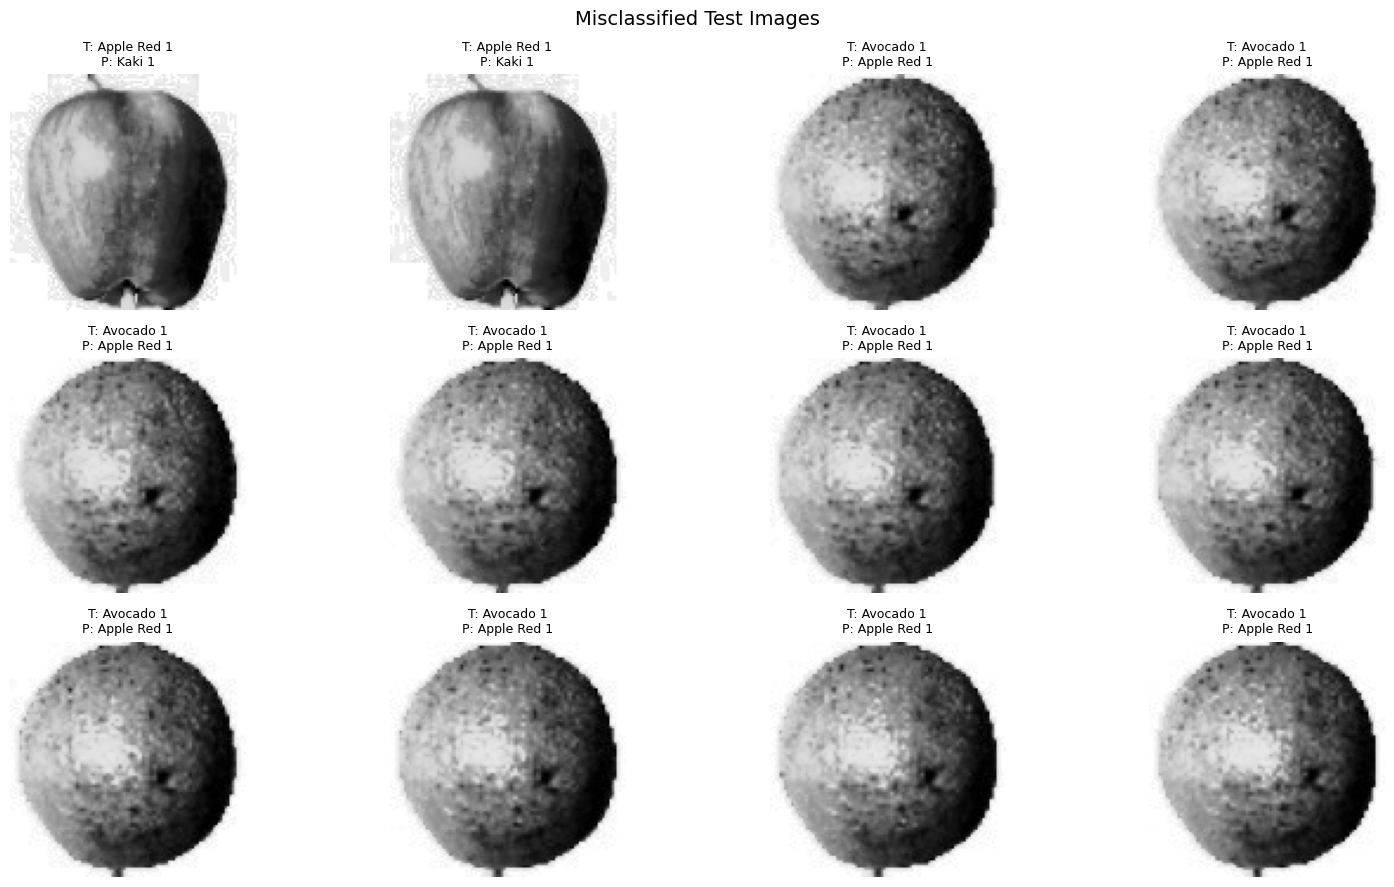

In [8]:
mis = plot_misclassified_images(
    model, 
    test_loader, 
    class_names, 
    device, 
    max_images=12, 
    save_path="../reports/figures/misclassified_baseline.png" 
)


#### 3.6.7 Visualize DataFrame of mistakes

In [5]:
df_mis = misclassified_to_df(mis, class_names)
df_mis.head()

,true,pred
0,Apple Red 1,Orange 1
1,Apple Red 1,Orange 1
2,Apple Red 1,Orange 1
3,Apple Red 1,Orange 1
4,Apple Red 1,Orange 1


#### 3.7 Improved CNN with Adaptive Pooling 

In [6]:
exp = "Grayscale AdaptiveAvgPool"
model = create_fruit_cnn(pooling="adaptiveavg", in_channels=in_ch, num_classes=len(class_names))
cfg = TrainConfig(epochs=10, lr=1e-3, early_stop_patience=5,
                  ckpt_path=f"../experiments/runs/{exp.replace(' ','_')}_best.pt", seed=42)

history, best_val = train_loop(model, train_loader, val_loader, class_weights, device, cfg)
test_acc = test_accuracy(model, cfg.ckpt_path, test_loader, device)
print(f"[{exp}] best_val={best_val:.4f} | test={test_acc:.4f}")

plot_buf = plot_training_curves(history["train_loss"], history["val_acc"])
results_summary[exp] = {
    "test_accuracy": test_acc,
    "train_losses": history["train_loss"],
    "val_accuracies": history["val_acc"],
    "plot": plot_buf,
    "ckpt": cfg.ckpt_path,
    "class_names": class_names,
    "in_channels": in_ch
}


Epoch 1/10 | loss 0.7025 | val_acc 0.9219
Epoch 2/10 | loss 0.2724 | val_acc 0.9878
Epoch 3/10 | loss 0.1728 | val_acc 0.9988
Epoch 4/10 | loss 0.1052 | val_acc 1.0000
Epoch 5/10 | loss 0.0780 | val_acc 0.9731
Epoch 6/10 | loss 0.0748 | val_acc 1.0000
Epoch 7/10 | loss 0.0575 | val_acc 1.0000
Epoch 8/10 | loss 0.0620 | val_acc 0.9976
Epoch 9/10 | loss 0.0531 | val_acc 1.0000
Early stopping.


/home/deyan/DEV/Softuni Data Science/Course Project Repo Here/data-science-course/src/train.py:60: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.

[Grayscale AdaptiveAvgPool] best_val=1.0000 | test=0.8718


* Despite expectations, max-pooling outperforms adaptive average pooling on both validation and test sets. This suggests that fine-grained textural activations are more helpful than global shape layout for this task, possibly due to lighting, resolution, or dataset scale.

#### 3.8 CNN with RGB Input

In this step, we extend our investigation by training the lightweight CNN model on **RGB images** instead of grayscale. This allows us to evaluate the **Grayscale Hypothesis**:

> *Grayscale input can be as effective as RGB for fruit classification, while reducing memory and compute requirements.*

By using the same model architecture with RGB inputs (3 channels), we can quantify any performance difference.


#### 3.8.1–3.8.2 Build RGB loaders (with/without noise)

In [7]:
# with noise
rgb_train, rgb_val, rgb_test, rgb_w, rgb_names, rgb_in_ch = make_dataloaders(
    TRAIN_DIR, TEST_DIR, batch_size=32, val_split=0.2, img_size=100,
    num_workers=0, seed=42, mode="rgb", use_noise=True, verbose=True
)

# without noise
rgb_train_clean, rgb_val_clean, rgb_test_clean, rgb_w_clean, rgb_names_clean, _ = make_dataloaders(
    TRAIN_DIR, TEST_DIR, batch_size=32, val_split=0.2, img_size=100,
    num_workers=0, seed=42, mode="rgb", use_noise=False, verbose=True
)


[INFO] Seed: 42
[INFO] Mode: rgb (in_channels=3, use_noise=True)
[INFO] Classes (8): ['Apple Red 1', 'Avocado 1', 'Banana 1', 'Kaki 1', 'Orange 1', 'Pineapple 1', 'Strawberry 1', 'Tomato 1']
[INFO] Sizes -> train: 3279, val: 819, test: 1365
[INFO] Class weights (mean≈1): [1.018 1.173 1.022 1.022 1.046 1.022 1.018 0.679]
[INFO] Seed: 42
[INFO] Mode: rgb (in_channels=3, use_noise=False)
[INFO] Classes (8): ['Apple Red 1', 'Avocado 1', 'Banana 1', 'Kaki 1', 'Orange 1', 'Pineapple 1', 'Strawberry 1', 'Tomato 1']
[INFO] Sizes -> train: 3279, val: 819, test: 1365
[INFO] Class weights (mean≈1): [1.018 1.173 1.022 1.022 1.046 1.022 1.018 0.679]


#### 3.8.3–3.8.4 Train & evaluate RGB variants

*RGB with noise*

In [8]:
exp = "RGB CNN With Noise"
model = create_fruit_cnn(pooling="max", in_channels=rgb_in_ch, num_classes=len(rgb_names))
cfg = TrainConfig(epochs=10, lr=1e-3, early_stop_patience=5,
                  ckpt_path=f"../experiments/runs/{exp.replace(' ','_')}_best.pt", seed=42)

history, best_val = train_loop(model, rgb_train, rgb_val, rgb_w, device, cfg)
test_acc = test_accuracy(model, cfg.ckpt_path, rgb_test, device)
print(f"[{exp}] best_val={best_val:.4f} | test={test_acc:.4f}")

plot_buf = plot_training_curves(history["train_loss"], history["val_acc"])
results_summary[exp] = {
    "test_accuracy": test_acc,
    "train_losses": history["train_loss"],
    "val_accuracies": history["val_acc"],
    "plot": plot_buf,
    "ckpt": cfg.ckpt_path,
    "class_names": rgb_names,
    "in_channels": rgb_in_ch
}


Epoch 1/10 | loss 0.4593 | val_acc 0.9951
Epoch 2/10 | loss 0.0696 | val_acc 0.9866
Epoch 3/10 | loss 0.0438 | val_acc 0.9988
Epoch 4/10 | loss 0.0444 | val_acc 0.9988
Epoch 5/10 | loss 0.0123 | val_acc 1.0000
Epoch 6/10 | loss 0.0349 | val_acc 1.0000
Epoch 7/10 | loss 0.0216 | val_acc 0.9988
Epoch 8/10 | loss 0.0114 | val_acc 1.0000
Epoch 9/10 | loss 0.0169 | val_acc 1.0000
Epoch 10/10 | loss 0.0079 | val_acc 0.9988
Early stopping.
[RGB CNN With Noise] best_val=1.0000 | test=0.8857


*RGB without noise*

In [9]:
exp = "RGB CNN Without Noise"
model = create_fruit_cnn(pooling="max", in_channels=rgb_in_ch, num_classes=len(rgb_names_clean))
cfg = TrainConfig(epochs=10, lr=1e-3, early_stop_patience=5,
                  ckpt_path=f"../experiments/runs/{exp.replace(' ','_')}_best.pt", seed=42)

history, best_val = train_loop(model, rgb_train_clean, rgb_val_clean, rgb_w_clean, device, cfg)
test_acc = test_accuracy(model, cfg.ckpt_path, rgb_test_clean, device)
print(f"[{exp}] best_val={best_val:.4f} | test={test_acc:.4f}")

plot_buf = plot_training_curves(history["train_loss"], history["val_acc"])
results_summary[exp] = {
    "test_accuracy": test_acc,
    "train_losses": history["train_loss"],
    "val_accuracies": history["val_acc"],
    "plot": plot_buf,
    "ckpt": cfg.ckpt_path,
    "class_names": rgb_names_clean,
    "in_channels": rgb_in_ch
}


Epoch 1/10 | loss 0.4418 | val_acc 0.9988
Epoch 2/10 | loss 0.0517 | val_acc 0.9951
Epoch 3/10 | loss 0.0265 | val_acc 0.9988
Epoch 4/10 | loss 0.0440 | val_acc 1.0000
Epoch 5/10 | loss 0.0114 | val_acc 1.0000
Epoch 6/10 | loss 0.0085 | val_acc 1.0000
Epoch 7/10 | loss 0.0118 | val_acc 1.0000
Epoch 8/10 | loss 0.0045 | val_acc 1.0000
Epoch 9/10 | loss 0.0600 | val_acc 1.0000
Early stopping.
[RGB CNN Without Noise] best_val=1.0000 | test=0.8857


#### 3.8.5 Visual summary / comparison

=== CNN Experiment Comparison ===
Grayscale MaxPool: Test Accuracy = 0.8337


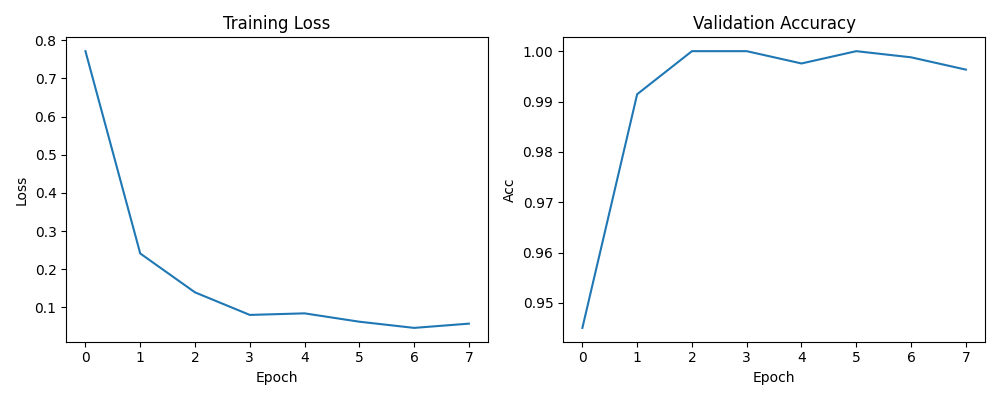

Grayscale AdaptiveAvgPool: Test Accuracy = 0.8718


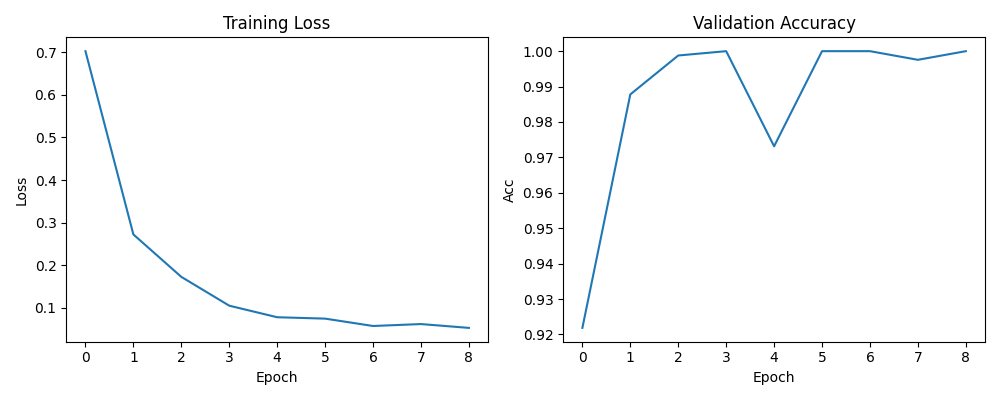

RGB CNN With Noise: Test Accuracy = 0.8857


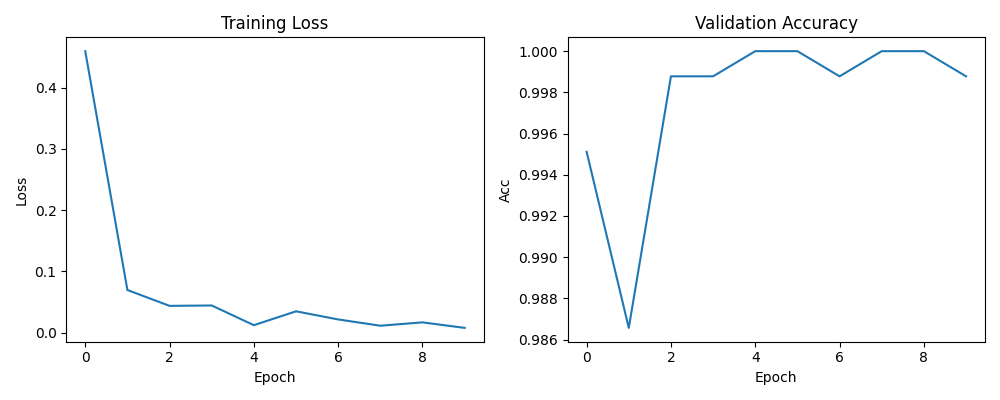

RGB CNN Without Noise: Test Accuracy = 0.8857


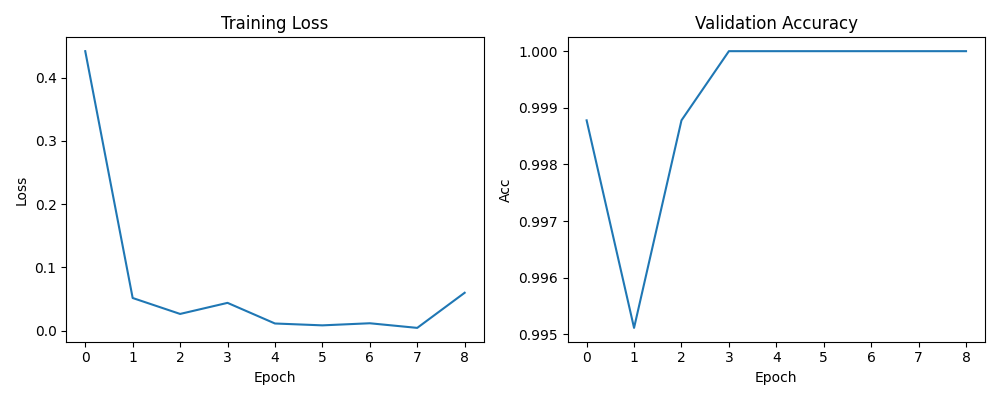

In [10]:
print("=== CNN Experiment Comparison ===")
for name, result in results_summary.items():
    print(f"{name}: Test Accuracy = {result['test_accuracy']:.4f}")
    img = Image.open(result["plot"])
    display(img)

#### 3.8.6 Save results summary to disk for comparison in step 4 

In [11]:
# === Step 3: replace your saving cell with this one (adds preds to JSON, no retraining) ===
import os, io, json, numpy as np, torch, re
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

# 🔁 EDIT if your builder path is different:
# e.g. from models.custom_cnn import create_fruit_cnn
from models.cnn_small import create_fruit_cnn

TEST_DIR = "../Dataset/Test"   # ensure this matches your project

os.makedirs("../experiments/plots", exist_ok=True)
os.makedirs("../experiments/results", exist_ok=True)

def slugify(s):  # for safe filenames
    return re.sub(r"[^a-zA-Z0-9_-]+", "_", s).strip("_")

def to_jsonable(x, *, name=None):
    import pathlib
    from PIL.Image import Image as PILImage
    if isinstance(x, torch.Tensor): return x.detach().cpu().tolist()
    if isinstance(x, np.ndarray):   return x.tolist()
    if isinstance(x, pathlib.Path): return str(x)
    if isinstance(x, io.BytesIO):
        fname = f"../experiments/plots/{slugify(name or 'plot')}.png"
        with open(fname, "wb") as f:
            f.write(x.getvalue())
        return fname
    if isinstance(x, PILImage):
        fname = f"../experiments/plots/{slugify(name or 'image')}.png"
        x.save(fname)
        return fname
    if isinstance(x, (bytes, bytearray)):
        fname = f"../experiments/plots/{slugify(name or 'blob')}.bin"
        with open(fname, "wb") as f:
            f.write(x)
        return fname
    return x

def _infer_input_type_from_entry(entry, name):
    in_ch = entry.get("in_channels", 3)
    nm = (name or "").lower()
    return "grayscale" if in_ch == 1 or "gray" in nm or "grayscale" in nm else "rgb"

def _normalize_pooling_from_name(name):
    nm = (name or "").lower()
    if "adaptive" in nm:
        # your create_fruit_cnn expects 'adaptiveavg'
        return "adaptiveavg"
    return "max"

def _make_test_loader(input_type, img_size=(100,100), batch_size=32):
    if input_type == "grayscale":
        tfm = transforms.Compose([
            transforms.Grayscale(),
            transforms.Resize(img_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5], std=[0.5]),
        ])
    else:
        tfm = transforms.Compose([
            transforms.Resize(img_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5]*3, std=[0.5]*3),
        ])
    ds = ImageFolder(TEST_DIR, transform=tfm)
    loader = DataLoader(ds, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
    return loader, ds.classes

def _safe_load_state(ckpt_path, device="cpu"):
    # PyTorch ≥ 2.4 supports weights_only=True (safer)
    try:
        return torch.load(ckpt_path, map_location=device, weights_only=True)
    except TypeError:
        return torch.load(ckpt_path, map_location=device)

@torch.no_grad()
def _preds_for_checkpoint(name, entry, device="cpu"):
    ckpt = entry.get("ckpt")
    if not ckpt or not os.path.exists(ckpt):
        return None, None, None  # skip if no weights

    input_type = _infer_input_type_from_entry(entry, name)
    test_loader, class_names = _make_test_loader(input_type)
    in_ch = entry.get("in_channels", 3)
    num_classes = len(class_names) if class_names else 8

    pooling = _normalize_pooling_from_name(name)

    model = create_fruit_cnn(
        pooling=pooling,
        in_channels=in_ch,
        num_classes=num_classes
    )

    state = _safe_load_state(ckpt, device=device)
    model.load_state_dict(state, strict=False)
    model.eval().to(device)

    ys, yhat, yprob = [], [], []
    for xb, yb in test_loader:
        xb = xb.to(device)
        logits = model(xb)
        prob = torch.softmax(logits, dim=1).cpu().numpy()
        pred = prob.argmax(1)
        ys.append(yb.numpy()); yhat.append(pred); yprob.append(prob)

    return (np.concatenate(ys), np.concatenate(yhat), np.concatenate(yprob))

# ---------- Build a JSON-safe copy and augment with predictions ----------
results_json = {}
for name, r in results_summary.items():
    safe = {}
    # keep your existing fields/history/plots/ckpt
    for k, v in r.items():
        if k == "history" and isinstance(v, dict):
            safe["history"] = {
                "train_loss": to_jsonable(v.get("train_loss", []), name=f"{name}_train_loss"),
                "val_acc":    to_jsonable(v.get("val_acc", []),    name=f"{name}_val_acc"),
            }
        elif k == "cm":
            safe["cm"] = to_jsonable(v, name=f"{name}_cm")
        else:
            safe[k] = to_jsonable(v, name=f"{name}_{k}")

    # NEW: attach predictions (y_true, y_pred, y_prob) for this CNN entry
    try:
        device = "cuda" if torch.cuda.is_available() else "cpu"
        y_true, y_pred, y_prob = _preds_for_checkpoint(name, safe, device=device)
        if y_true is not None:
            safe["y_true"] = to_jsonable(y_true, name=f"{name}_y_true")
            safe["y_pred"] = to_jsonable(y_pred, name=f"{name}_y_pred")
            safe["y_prob"] = to_jsonable(y_prob, name=f"{name}_y_prob")
    except Exception as e:
        print(f"[WARN] Could not produce preds for '{name}': {e}")

    results_json[name] = safe

with open("../experiments/results/custom_cnn_results.json", "w", encoding="utf-8") as f:
    json.dump(results_json, f, ensure_ascii=False, indent=2)

print("Saved → ../experiments/results/custom_cnn_results.json (with y_true/y_pred/y_prob)")


Saved → ../experiments/results/custom_cnn_results.json (with y_true/y_pred/y_prob)
